# Ground temperature history inversion

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend
from heat import heat

# Generate the data kernel matrix, G

In [195]:
start_year = 1923
end_year = 2023
number_of_time_steps = 199
max_depth = 150
tsurf_avg=0

t = np.linspace(start_year,end_year, number_of_time_steps+1)

U,t,z = heat(np.zeros(len(t)),tmax=end_year,tmin=start_year,nt=number_of_time_steps,zmax=max_depth,
            dTdz=0)
nz = len(z)
G = np.zeros((nz,number_of_time_steps))
for i in range(number_of_time_steps):

    delta = tsurf_avg*np.ones(number_of_time_steps)
    delta[i] = 1

    U,t,z = heat(delta,tmax=end_year,tmin=start_year,nt=number_of_time_steps,zmax=max_depth,
            dTdz=0)
    nz = len(z)
    G[:,i] = U[:,-1]

(150.0, 3.75)

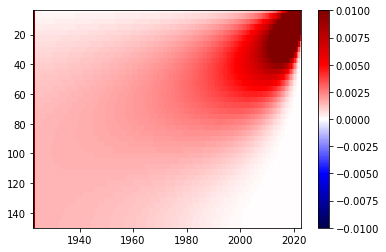

In [196]:
vm=0.01
c=plt.pcolormesh(t[0:-1],z,G,vmin=-vm,vmax=vm,cmap='seismic')
plt.colorbar(c)
plt.ylim([z[-1],z[0]])

# Synthetic inverse problem
## First, make some synthetic data and add noise

In [178]:
synthetic_history = np.zeros(number_of_time_steps)
synthetic_history[number_of_time_steps//2:] = 1

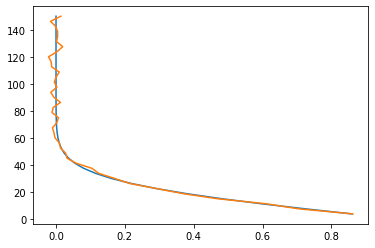

In [179]:
synthetic_data = np.matmul(G,synthetic_history)
synthetic_data_noise = synthetic_data + np.random.normal(loc=0, scale=0.01, size=synthetic_data.shape)
plt.plot(synthetic_data,z)
plt.plot(synthetic_data_noise,z)

# Invert the noisy data

## First attempt: linear least squares

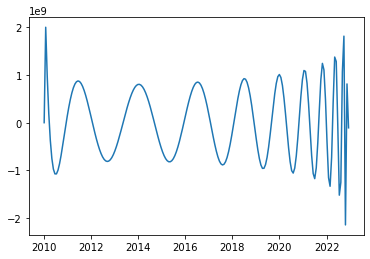

In [180]:
x, residuals, rank, singular_values = np.linalg.lstsq(G, synthetic_data_noise, rcond=None)
plt.plot(t[0:-1],x)

## Second attempt: damped least squares

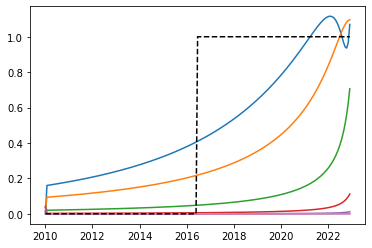

In [181]:
for lmbda in np.logspace(-3,3,7): # Damping parameter (regularization parameter)

    # Formulate the regularized least squares problem
    # We need to augment A with the regularization term
    A_augmented = np.vstack([G, np.sqrt(lmbda) * np.eye(G.shape[1])])
    b_augmented = np.concatenate([synthetic_data_noise, np.zeros(G.shape[1])])

    # Solve the regularized least squares problem
    x_damped, residuals, rank, singular_values = np.linalg.lstsq(A_augmented, b_augmented, rcond=None)
    plt.plot(t[0:-1],x_damped)
    
plt.plot(t[0:-1],synthetic_history,'--k')

## Third attempt: SVD method

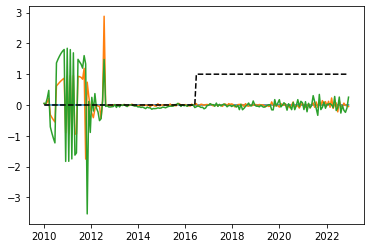

In [191]:
U,S,V = np.linalg.svd(G)
for n in np.linspace(1,3,3).astype(int):
    Sinv = np.diag(1/S[0:n])
    Gg = np.matmul(np.matmul(V[:,0:n] , Sinv), U[:,0:n].T)
    x =  np.matmul(Gg, synthetic_data_noise)
    plt.plot(t[0:-1],x)
plt.plot(t[0:-1],synthetic_history,'--k')

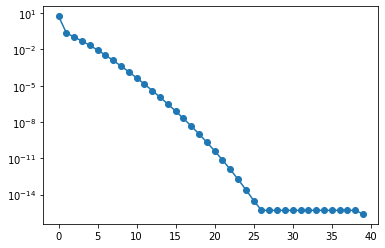

In [194]:
plt.semilogy(S,'-o')